# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо достичь значение *F1*-меры на тестовой выборке выше 0.59.
Дополнительно измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных.

**Признаки:**

-	RowNumber — индекс строки в данных
-	CustomerId — уникальный идентификатор клиента
-	Surname — фамилия
-	CreditScore — кредитный рейтинг
-	Geography — страна проживания
-	Gender — пол
-	Age — возраст
-	Tenure — количество недвижимости у клиента
-	Balance — баланс на счёте
-	NumOfProducts — количество продуктов банка, используемых клиентом
-	HasCrCard — наличие кредитной карты
-	IsActiveMember — активность клиента
-	EstimatedSalary — предполагаемая зарплата

**Целевой признак:**

-	Exited — факт ухода клиента

# 1. Подготовка данных

Загрузим все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import joblib
import seaborn as sns
from sklearn.utils import shuffle

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings('ignore')

Прочтем файл, посмотрим на первые 10 строчек и информацию о таблице.

In [7]:
data = pd.read_csv('/datasets/Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [9]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Датафрейм состоит из 14 столбцов и 10000 строк. В столбце с кол-вом недвижимости у клиента присутствуют пропуски, их необходимо заполнить. Если банк не обладает информацией о кол-ве недвижимости у клиента, то для банка это может быть приравнено к отсутствию этой самой недвижимости, поэтому приравняем пропуски к нулю.

In [10]:
data[data['Tenure'] == 0]['Tenure'].count()

382

In [11]:
data['Tenure'] = data['Tenure'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Преобразуем количественные переменные в целочисленный формат.

In [12]:
columns = ['Tenure', 'Balance', 'EstimatedSalary']
data[columns] = data[columns].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   RowNumber        10000 non-null  int64 
 1   CustomerId       10000 non-null  int64 
 2   Surname          10000 non-null  object
 3   CreditScore      10000 non-null  int64 
 4   Geography        10000 non-null  object
 5   Gender           10000 non-null  object
 6   Age              10000 non-null  int64 
 7   Tenure           10000 non-null  int64 
 8   Balance          10000 non-null  int64 
 9   NumOfProducts    10000 non-null  int64 
 10  HasCrCard        10000 non-null  int64 
 11  IsActiveMember   10000 non-null  int64 
 12  EstimatedSalary  10000 non-null  int64 
 13  Exited           10000 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 1.1+ MB


Столбцы с индексом строки и фамилиями клиентов не пригодятся для последующей работы, поэтому удалим их.

In [13]:
data = data.drop(['RowNumber', 'Surname'], axis=1)

# 2. Исследование задачи

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования в виду того, что планируется протестировать модель логистической регрессии. Также, чтобы избежать дамми-ловушки удалим первый столбец аргументом *drop_first* 

In [14]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,15634602,619,42,2,0,1,1,1,101348,1,0,0,0
1,15647311,608,41,1,83807,1,0,1,112542,0,0,1,0
2,15619304,502,42,8,159660,3,1,0,113931,1,0,0,0
3,15701354,699,39,1,0,2,0,0,93826,0,0,0,0
4,15737888,850,43,2,125510,1,1,1,79084,0,0,1,0


Построим диаграммы рассеяния по основным количественным признакам, чтобы понять существует ли существенная разница между ушедшими и оставшимися в банке клиентами.

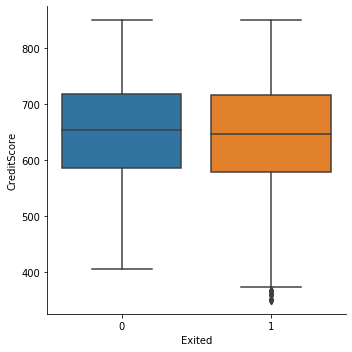

In [72]:
sns.catplot(x='Exited', y='CreditScore', kind='box', data=data_ohe);

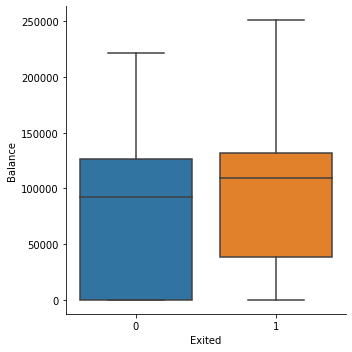

In [73]:
sns.catplot(x='Exited', y='Balance', kind='box', data=data_ohe);

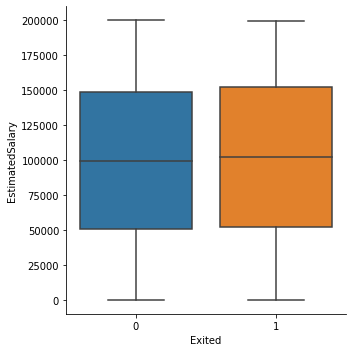

In [74]:
sns.catplot(x='Exited', y='EstimatedSalary', kind='box', data=data_ohe);

Можно заметить, что по исследованным признакам - кредитный рейтинг, баланс и предполагаемая зарплата существенных различий не наблюдается. Однако характерно большое кол-во существующих клиентов с нулевым балансом - возможно они неактивно используют банковские услуги.

Существует ли зависимость между основными признаками?

Чтобы ответить на этот вопрос, построим матрицу корреляции для 4-х признаков - кредитный рейтинг, баланс, возраст и предполагаемая зарплата.

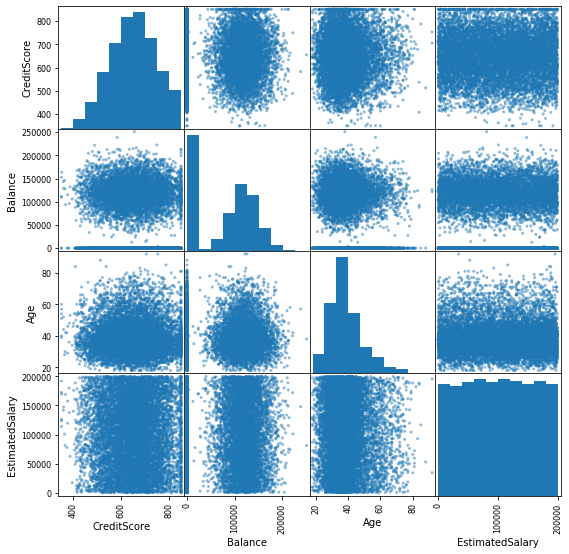

In [75]:
new_df = data_ohe[['CreditScore', 'Balance', 'Age', 'EstimatedSalary']]
pd.plotting.scatter_matrix(new_df, figsize=(9, 9));

Между рассмотренными признаками явной зависимости не наблюдается, а значит каждый из них может повлиять на качество модели.

Стоит также заметить равномерное распределение предполагаемой зарплаты клиентов, возможно она не будет оказывать влияния на модель, рассмотрим это в последующем анализе.

Для начала удалим столбец с Id клиентов (он не влияет на задачу) и поделим выборку со следующим соотношением:

- тренировочная - 60%
- валидационная (проверочная) - 20%
- тестовая - 20%

In [15]:
new_data = data_ohe.drop(['CustomerId'], axis=1)
df_train, df_valid = train_test_split(new_data, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid , test_size=0.5, random_state=12345)

In [16]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

Отмасштабируем все количественные признаки путем стандартизации.

In [17]:
numeric = ['CreditScore', 'Tenure', 'Balance', 'Age', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Первой обучим модель случайного леса.

Здесь есть два ключевых параметра - максимальная глубина и число оценщиков (деревьев), поэтому в двойном цикле пройдемся по этим параметрам, при этом кол-во деревьев будем менять от 5 до 50 с шагом 5, глубина - от 1 до 10 с шагом 1. Запишем каждый параметр и ключевую метрику f1 модели, полученной при этом наборе параметров, в отдельные списки, чтобы потом объединить их в общий датафрейм и найти наиболее выгодный набор параметров.

In [18]:
f1_list=[]
max_depth_list=[]
n_est_list=[]
for n in range(5, 51, 5):
    for i in range(1, 10):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=i, n_estimators=n)
        model_rf.fit(features_train, target_train)
        predictions = model_rf.predict(features_valid)
        f1 = f1_score(target_valid, predictions)
        f1_list.append(f1)
        max_depth_list.append(i)
        n_est_list.append(n)

Запишем полученные списки в общий датафрейм и отсортируем его по f1.

In [19]:
df = pd.DataFrame(
    {'n_estimators': n_est_list, 
     'max_depth': max_depth_list, 
     'f1' : f1_list})
df.sort_values(by='f1', ascending=False).head()

,n_estimators,max_depth,f1
17,10,9,0.580060
8,5,9,0.576923
89,50,9,0.574961
35,20,9,0.574961
71,40,9,0.574103


F1 = 0.58 даже на валидационной выборке однозначно не дает нам нужного результата.
Проверим еще две модели - логистическую регрессию и дерево решений.

In [81]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.33670033670033667

In [82]:
for i in range(2, 10):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=i)
    model_dt.fit(features_train, target_train)
    predicted_valid = model_dt.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print('max_depth =', i, ':', f1)

max_depth = 2 : 0.5217391304347825
max_depth = 3 : 0.4234875444839857
max_depth = 4 : 0.5528700906344411
max_depth = 5 : 0.5406249999999999
max_depth = 6 : 0.5696969696969697
max_depth = 7 : 0.5320813771517998
max_depth = 8 : 0.5449010654490106
max_depth = 9 : 0.5786516853932585


На данном этапе заметно, что ни одна модель не обеспечивает необходимую полноту и точность (т.е f1), однако в наших данных присутсвует дисбаланс, от которого в последствие избавимся.

На модели случайного леса, показавшего наилучший результат среди трех проверенных, проверим степени влияния каждого признака на итоговое решение и построим гистограмму для этих степеней.

Feature ranking:
1. feature 1 (0.333624) -- CreditScore
2. feature 4 (0.217983) -- Age
3. feature 3 (0.100856) -- Tenure
4. feature 6 (0.076349) -- Balance
5. feature 0 (0.074620) -- NumOfProducts
6. feature 7 (0.069314) -- HasCrCard
7. feature 8 (0.046844) -- IsActiveMember
8. feature 2 (0.038494) -- EstimatedSalary
9. feature 10 (0.023797) -- Geography_Germany
10. feature 5 (0.010479) -- Geography_Spain
11. feature 9 (0.007641) -- Gender_Male


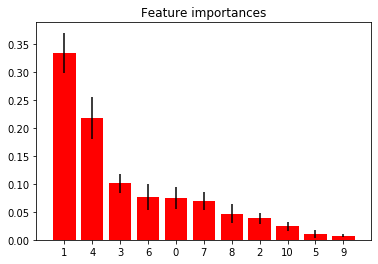

In [83]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=10)
model_rf.fit(features_train, target_train)
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(features_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), '--', features_train.columns[f])

plt.figure()
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features_train.shape[1]), indices)
plt.xlim([-1, features_train.shape[1]])
plt.show()

Самым малозначимым признаком оказался признак пола. Удалим его и проверим как это повлияет на f1 каждой модели.

In [84]:
features_train_2 = df_train.drop(['Exited', 'Gender_Male'], axis=1)
features_valid_2 = df_valid.drop(['Exited', 'Gender_Male'], axis=1)
features_test_2 = df_test.drop(['Exited', 'Gender_Male'], axis=1)

model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=10)
model_rf.fit(features_train_2, target_train)
predictions = model_rf.predict(features_valid_2)
f1 = f1_score(target_valid, predictions)
f1

0.5660964230171073

In [85]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_2, target_train)
predicted_valid = model.predict(features_valid_2)
f1_score(target_valid, predicted_valid)

0.08385744234800838

In [87]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=9)
model_dt.fit(features_train_2, target_train)
predicted_valid = model_dt.predict(features_valid_2)
f1 = f1_score(target_valid, predicted_valid)
f1

0.5702364394993046

На всех моделях значение метрики f1 упало, но потребуется дополнительная проверка после решение проблемы с дисбалансом.

### Вывод.

Категориальные признаки были преобразованы в количественные.

Проведен первичный анализ входных данных.

Обучив три модели - случайного леса, дерева решений и логистической регрессии - получено недостаточное значение ключевой f1 метрики, связанной с дисбалансом классов.

# 3. Борьба с дисбалансом

Проверим в каком соотношении находится кол-во ушедших клиентов к оставшимся.

In [88]:
data_ohe['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Соотношение близко к 1:4.

Для решения проблемы дисбаланса классов попробуем два подхода - увеличение выборки и уменьшение.

**Увеличение выборки.**

Преобразование проходит в несколько этапов:

- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные

Для осуществления этих этапов создадим функцию *upsample*, принимающую на вход признаки, ключевой признак и кол-во повторений.

In [90]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Для нормального баланса достаточно увеличить выборку положительных результатов в 3 раза.

In [91]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

Обучим модель случайного леса с новыми сбалансированными данными.

In [92]:
model_rf_1= RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=10)
model_rf_1.fit(features_upsampled, target_upsampled)
predictions = model_rf_1.predict(features_valid)
f1 = f1_score(target_valid, predictions)
f1

0.6096131301289567

F1 выросла практически до 0.61, но можно проверить как поведет себя модель, если мы используем *features_train_2* - признаки без учета гендера.

In [93]:
features_upsampled, target_upsampled = upsample(features_train_2, target_train, 3)

In [94]:
model_rf_1= RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=10)
model_rf_1.fit(features_upsampled, target_upsampled)
predictions = model_rf_1.predict(features_valid_2)
f1 = f1_score(target_valid, predictions)
f1

0.6200466200466201

Результат вырос еще на процент, поэтому в последующем будем отталкиваться только от этих признаков.

Проверим результаты для дерева решений и логистической регрессии.

In [95]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=9)
model_dt.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt.predict(features_valid_2)
f1 = f1_score(target_valid, predicted_valid)
f1

0.5318918918918919

In [96]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train_2, target_train)
predicted_valid = model.predict(features_valid_2)
f1_score(target_valid, predicted_valid)

0.45890968266883647

Значение на этих моделях по прежнему значительно ниже модели случайного леса. Соответсвенно модель случайного леса выбираем в качестве основной.

**Уменьшение выборки.**

Преобразование проходит в несколько этапов:

- Разделить обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросить часть из отрицательных объектов;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные

Для осуществления этих этапов создадим функцию *downsample*, принимающую на вход признаки, ключевой признак и долю оставшихся после отбрасывания отрицательных объектов.

In [97]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Оставим треть отрицательных объектов и заново обучим модель случайного леса.

In [105]:
features_downsampled, target_downsampled = downsample(features_train_2, target_train, 0.33)

In [106]:
model_rf_2 = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=10)
model_rf_2.fit(features_downsampled, target_downsampled)
predictions = model_rf_2.predict(features_valid_2)
f1 = f1_score(target_valid, predictions)
f1

0.589247311827957

Значение f1 оказалось заметно ниже, чем полученное путем увеличение выборки, поэтому основной выберем первую модель.

Для оценки того, насколько наша модель отличается от случайной, построим кривую ошибок (ROC-кривая) и вычислим площадь под этой кривой (метрика AUC-ROC).

Для этого посичтаем вероятность положительного класса и построим график для переменных *fpr* (доля ложноположительных ответов) и *tpr* (доля истинно положительных ответов).

In [110]:
probabilities_valid = model_rf_1.predict_proba(features_valid_2)
probabilities_one_valid = probabilities_valid[:, 1]

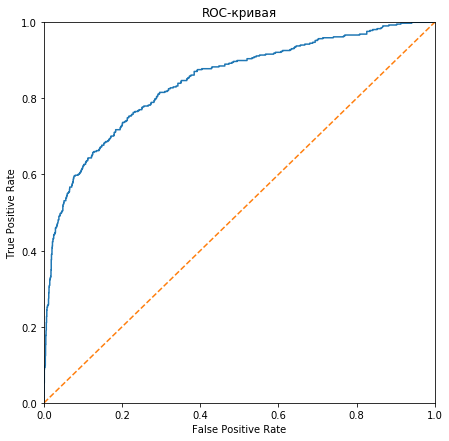

In [111]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")

plt.show()

Оценим метрику *AUC-ROC*.

In [112]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8445573406565489

Значение 0.84 показывает, что наша модель работает адекватно и предсказывает значения лучше случайной модели.

### Вывод.

Было проверено два способа борьбы с дисбалансом классов, выбран способ увеличения выборки.

С помощью кривой ошибок и метрики *AUC-ROC* была доказана адекватность полученной модели.

# 4. Тестирование модели

Проверим нашу модель на тестовой выборке.

In [113]:
predictions = model_rf_1.predict(features_test_2)
f1 = f1_score(target_test, predictions)
f1

0.5965714285714285

Модель показывает метрику F1 больше необходимого значения на тестовой выборке. Таким образом, условие о минимальном значении метрики F1 в 0,59 - выполнено.

Проверим метрику *AUC-ROC* на тестовой выборке.

In [56]:
probabilities_test = model_rf_1.predict_proba(features_test_2)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8574529547829242

Значение метрики близкое к 0.86 также говорит о достаточном качетсве модели.

# Вывод.

- Входные данные были подготовлены, заполнены пропуски.
- Был проведен предварительный анализ полученных данных.
- Оценена ключевая метрика F1 для трех моделей (случайного леса, дерева решений и логистической регрессии) без учета дисбаланса классов.
- Проведена балансировка классов путем увеличения выборки
- Наибольшую точность и полноту показала модель случайного леса.
- Для модели случайного леса были подобраны оптимальные параметры.
- Исследована кривая ошибок и метрика AUC-ROC.
- На тестовой выборке получено необходимое значение F1 метрики.


# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*